Dataset link: https://www.kaggle.com/datasets/meirnizri/covid19-dataset/data

Goal - explore the dataset, compare Decision Tree Classifier and Logistic Regression for predicting death among patients.

Project is divided into 3 parts:

1. Loading and preprocessing
2. Exploration and visualization
3. Creation and comparison of the chosen ML models

Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calmap

import requests
import io

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.simplefilter('ignore')

### Loading and preprocessing

In [2]:
df = pd.read_csv('C:/Users/N1K1/Downloads/jupyter/Code/Data_architect/Covid_Data.csv')
df.columns = df.columns.str.lower() # сделаем названия колонок нижним регистром, чтобы было удобнее к ним обращаться
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   usmer                 1048575 non-null  int64 
 1   medical_unit          1048575 non-null  int64 
 2   sex                   1048575 non-null  int64 
 3   patient_type          1048575 non-null  int64 
 4   date_died             1048575 non-null  object
 5   intubed               1048575 non-null  int64 
 6   pneumonia             1048575 non-null  int64 
 7   age                   1048575 non-null  int64 
 8   pregnant              1048575 non-null  int64 
 9   diabetes              1048575 non-null  int64 
 10  copd                  1048575 non-null  int64 
 11  asthma                1048575 non-null  int64 
 12  inmsupr               1048575 non-null  int64 
 13  hipertension          1048575 non-null  int64 
 14  other_disease         1048575 non-null  int64 
 15

,usmer,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnant,diabetes,...,asthma,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [3]:
# replacing numbers to 0 (female) and 1 (male)

df['sex'] = df['sex'].replace({1:0,2:1})

# replace  severity of disease, taking into account that numbers 4-7 mean that the person did not have it or the test was ambiguous

df['clasiffication_final'] = df['clasiffication_final'].replace({7:0, 6:0, 5:0, 4:0}) 

In [18]:
# changing, where possible, numerical values to 0, 1, and nan in accordance with the description

mask = ['intubed','pneumonia','diabetes','copd','asthma','inmsupr','hipertension',
'other_disease','cardiovascular','obesity','renal_chronic','tobacco','icu','patient_type']
df.loc[:, mask] = df.loc[:, mask].replace({99:np.nan, 98:np.nan, 97:np.nan, 1:1, 2:0})

In [19]:
print(df[['pregnant','sex']].value_counts()) # values "97" in column "pregnant" are related to males only
df['pregnant'] = df['pregnant'].replace({98:np.nan, 97:0, 1:1, 2:0}) # changing to 0, 1, and nan taking into account the above

pregnant  sex
97        1      523511
2         0      513179
1         0        8131
98        0        3754
Name: count, dtype: int64


In [20]:
# removing columns where more than 80% are missing values (although there are doubts that these are actually missing values, since these columns indicate
# whether the patient was in intensive care and was connected to a ventilator, nevertheless, we will follow the description)

print(df.isna().sum()/len(df)*100)
df = df.drop(columns = ['intubed','icu'])

usmer                    0.000000
medical_unit             0.000000
sex                      0.000000
patient_type             0.000000
date_died                0.000000
intubed                 81.622106
pneumonia                1.526166
age                      0.000000
pregnant                 0.358010
diabetes                 0.318337
copd                     0.286389
asthma                   0.284100
inmsupr                  0.324631
hipertension             0.296021
other_disease            0.481129
cardiovascular           0.293350
obesity                  0.289154
renal_chronic            0.286675
tobacco                  0.307083
clasiffication_final     0.000000
icu                     81.637651
dtype: float64


In [21]:
# + deleting lines where there is at least one missing value, because there are few of them - about 2.5%

print(df.isna().any(axis=1).sum())
print(df.isna().any(axis=1).sum()/df.shape[0])

df = df.dropna().reset_index(drop=True)

26598
0.025365853658536587


In [22]:
# bringing to uniform datatypes
df = df.astype({col: 'int32' for col in df.select_dtypes(['float64','int64']).columns})

In [23]:
df['date_died'] = df['date_died'].replace({'9999-99-99':np.nan})
df['date_died'] = pd.to_datetime(df['date_died'], format = '%d/%m/%Y') # date formatting
df['died'] = np.where(df['date_died'].isna(), False, True) # creating a new column with boolean values: True - dead, False - not dead

In [24]:
df.info() # prepared dataset was reduced to 1 mln 22 th. rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021977 entries, 0 to 1021976
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   usmer                 1021977 non-null  int32         
 1   medical_unit          1021977 non-null  int32         
 2   sex                   1021977 non-null  int32         
 3   patient_type          1021977 non-null  int32         
 4   date_died             74657 non-null    datetime64[ns]
 5   pneumonia             1021977 non-null  int32         
 6   age                   1021977 non-null  int32         
 7   pregnant              1021977 non-null  int32         
 8   diabetes              1021977 non-null  int32         
 9   copd                  1021977 non-null  int32         
 10  asthma                1021977 non-null  int32         
 11  inmsupr               1021977 non-null  int32         
 12  hipertension          1021977 non-null  in

Exploration and visualization

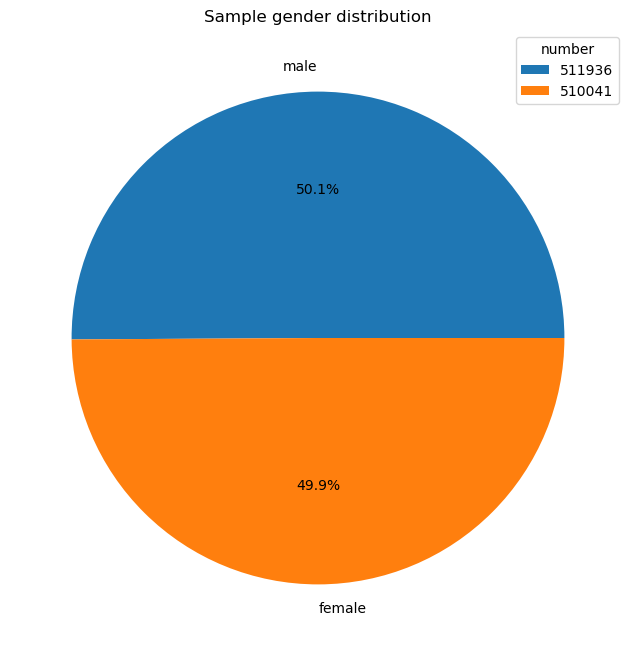

In [25]:
# sample is almost evenly divided by gender

plt.figure(figsize = (14, 8))
plt.title('Sample gender distribution')
plt.pie(df['sex'].value_counts(), labels = ['male', 'female'], autopct = '%1.1f%%')
plt.legend(df['sex'].value_counts(), title = 'number')

plt.show()

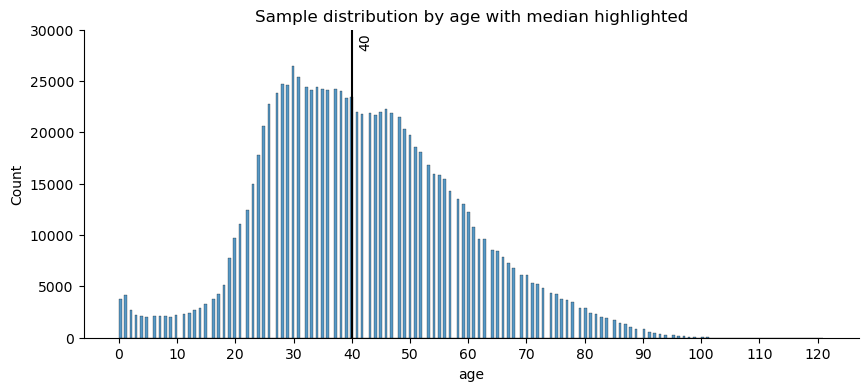

In [26]:
# median age is 40 years old

median_age = df['age'].median()

plt.figure(figsize=(10,4))
sns.histplot(x=df['age'])
plt.axvline(median_age, color='black')
plt.title('Sample distribution by age with median highlighted')

ax = plt.gca()
ax.set_ylim(top=30000)
ymax = plt.ylim()[1]

plt.annotate(f'{median_age:.0f}', xy=(median_age, ymax), xytext=(10, -15), textcoords='offset points',
             rotation=90, va='bottom', ha='center', annotation_clip=False)
plt.xticks(np.arange(0,df['age'].max(),10))

sns.despine()
plt.show()

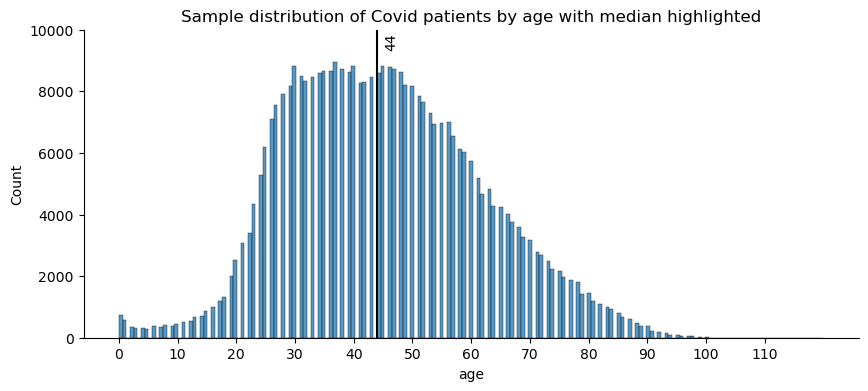

In [27]:
# median age of Covid patients is 44 years old

median_age = df.loc[df['clasiffication_final']!=0,'age'].median()

plt.figure(figsize=(10,4))
sns.histplot(x=df.loc[df['clasiffication_final']!=0,'age'])
plt.axvline(median_age, color='black')
plt.title('Sample distribution of Covid patients by age with median highlighted')

ax = plt.gca()
ax.set_ylim(top=10000)
ymax = plt.ylim()[1]

plt.annotate(f'{median_age:.0f}', xy=(median_age, ymax), xytext=(10, -15), textcoords='offset points',
             rotation=90, va='bottom', ha='center', annotation_clip=False)
plt.xticks(np.arange(0,df.loc[df['clasiffication_final']!=0,'age'].max(),10))

sns.despine()
plt.show()

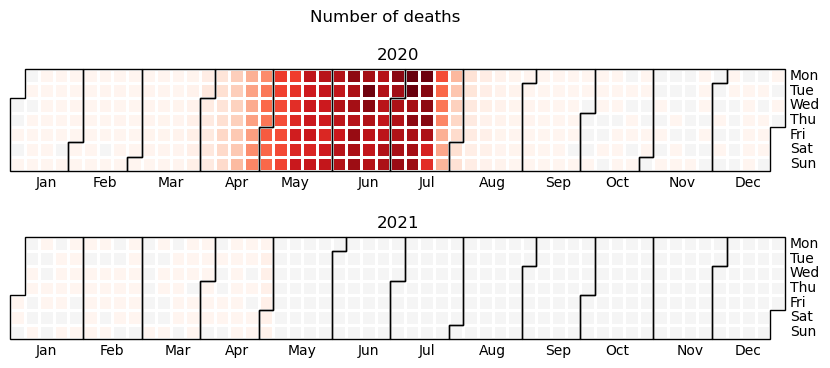

In [28]:
# peak of mortality occurred in May-July 2020

events  = df.groupby('date_died')['died'].sum()
fig, axs = plt.subplots (2,1,figsize=(10,4))
years = df[df['date_died'].notna()]['date_died'].dt.year.unique()
for i, year in enumerate(years):
    calmap.yearplot(events, year=year, monthly_border=True, ax=axs[i])
    axs[i].set_title(year)

fig.suptitle('Number of deaths')
plt.show()

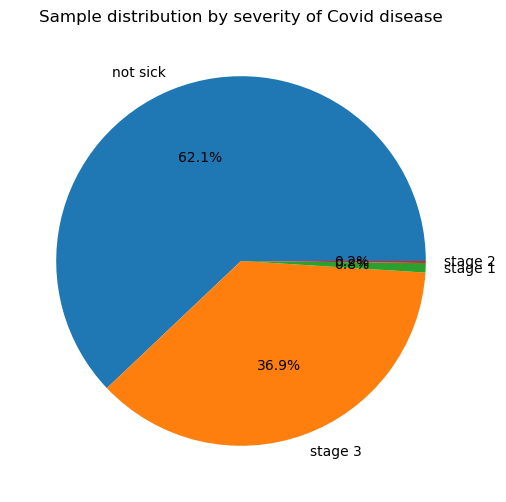

In [29]:
# patients were mainly diagnosed with stage 3 Covid; more than 60% of the sample did not have it

plt.figure(figsize = (12, 6))
labels = df['clasiffication_final'].value_counts().sort_values(ascending=False).index.unique()
true_labels = []
for l in labels:
    l = 'stage ' + str(l)
    if l == 'stage 0':
        l = 'not sick'
    true_labels.append(l)
plt.pie(df['clasiffication_final'].value_counts(), labels = true_labels, autopct = '%.1f%%')

plt.title('Sample distribution by severity of Covid disease')
plt.show()

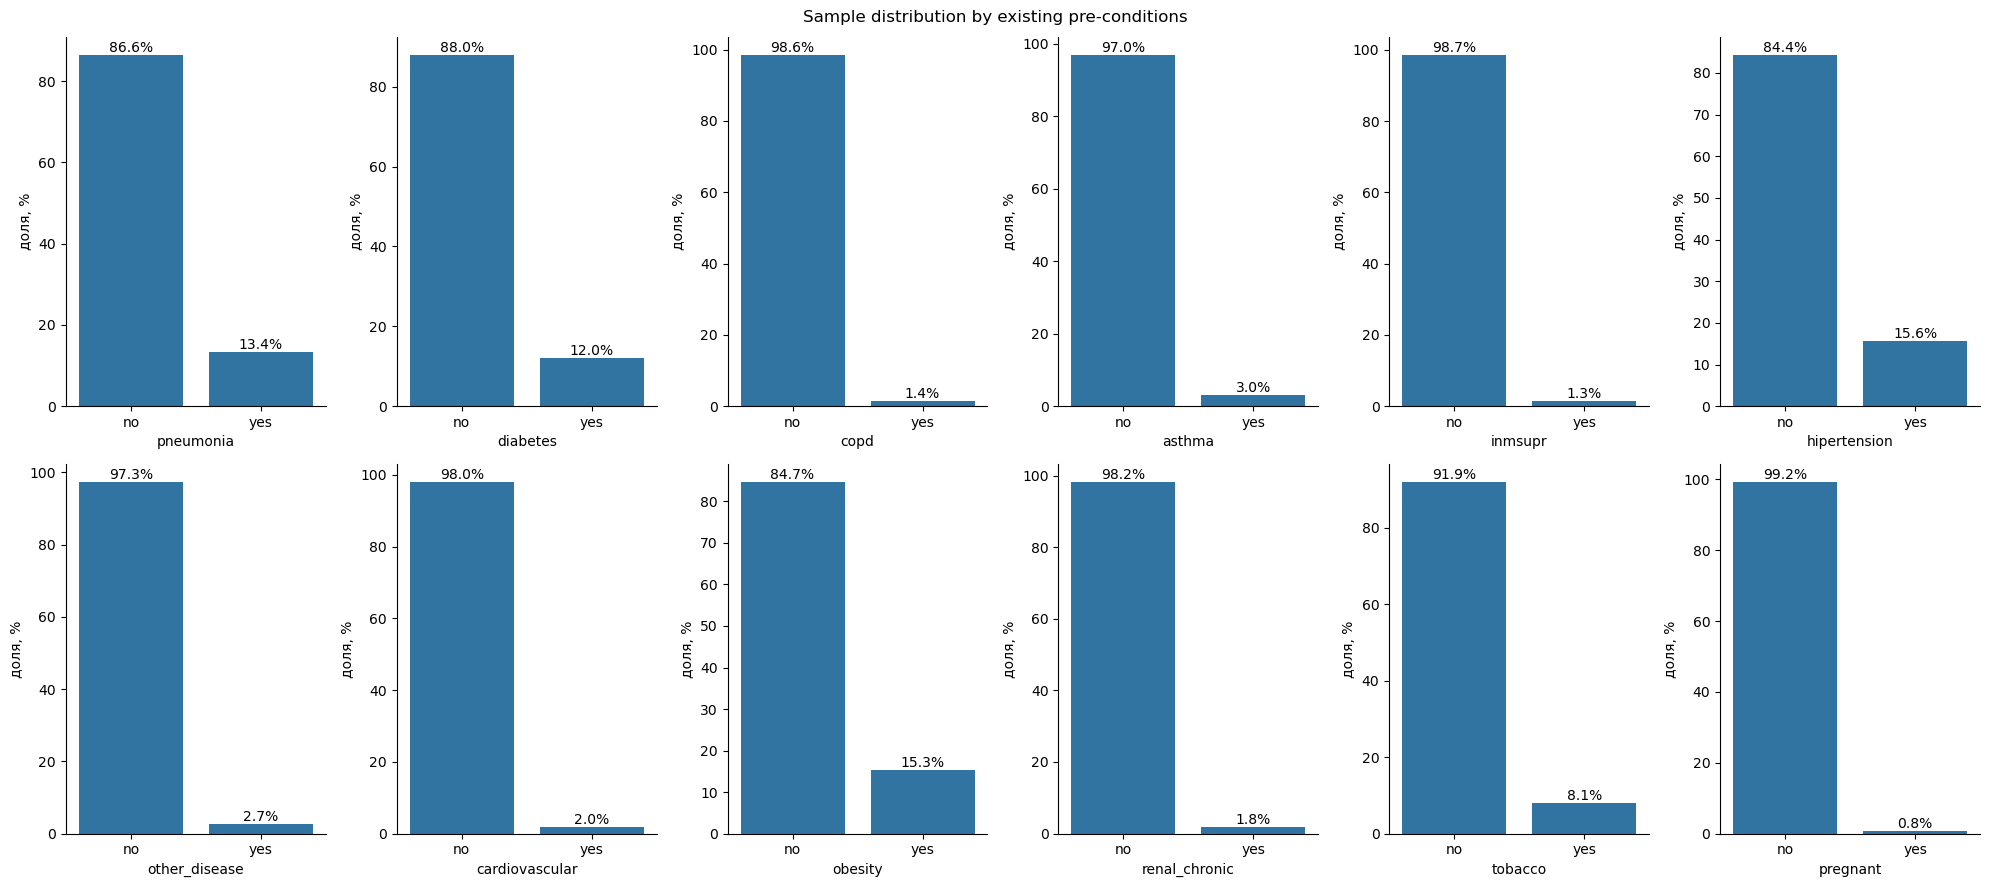

In [32]:
# the proportion of different pre-conditions of patients in the sample:
# they most often suffered from obesity, high blood pressure, pneumonia (possibly related to covid) and diabetes

conditions_list = ['pneumonia','diabetes','copd','asthma','inmsupr','hipertension',
'other_disease','cardiovascular','obesity','renal_chronic','tobacco', 'pregnant']

fig = plt.figure(figsize=(20,9))

for num, condition in enumerate(conditions_list):
    ax = fig.add_subplot(2,6,num+1)
    sns.countplot(df, x = condition, stat = 'percent')
    values = df[condition].value_counts(ascending=False).values
    ax.set_xticklabels(['no','yes'])
    plt.xlabel(condition)
    plt.ylabel('доля, %')
    ax.bar_label(ax.containers[0], fmt='%.1f%%')

plt.suptitle('Sample distribution by existing pre-conditions')
sns.despine()
plt.tight_layout()
plt.show()

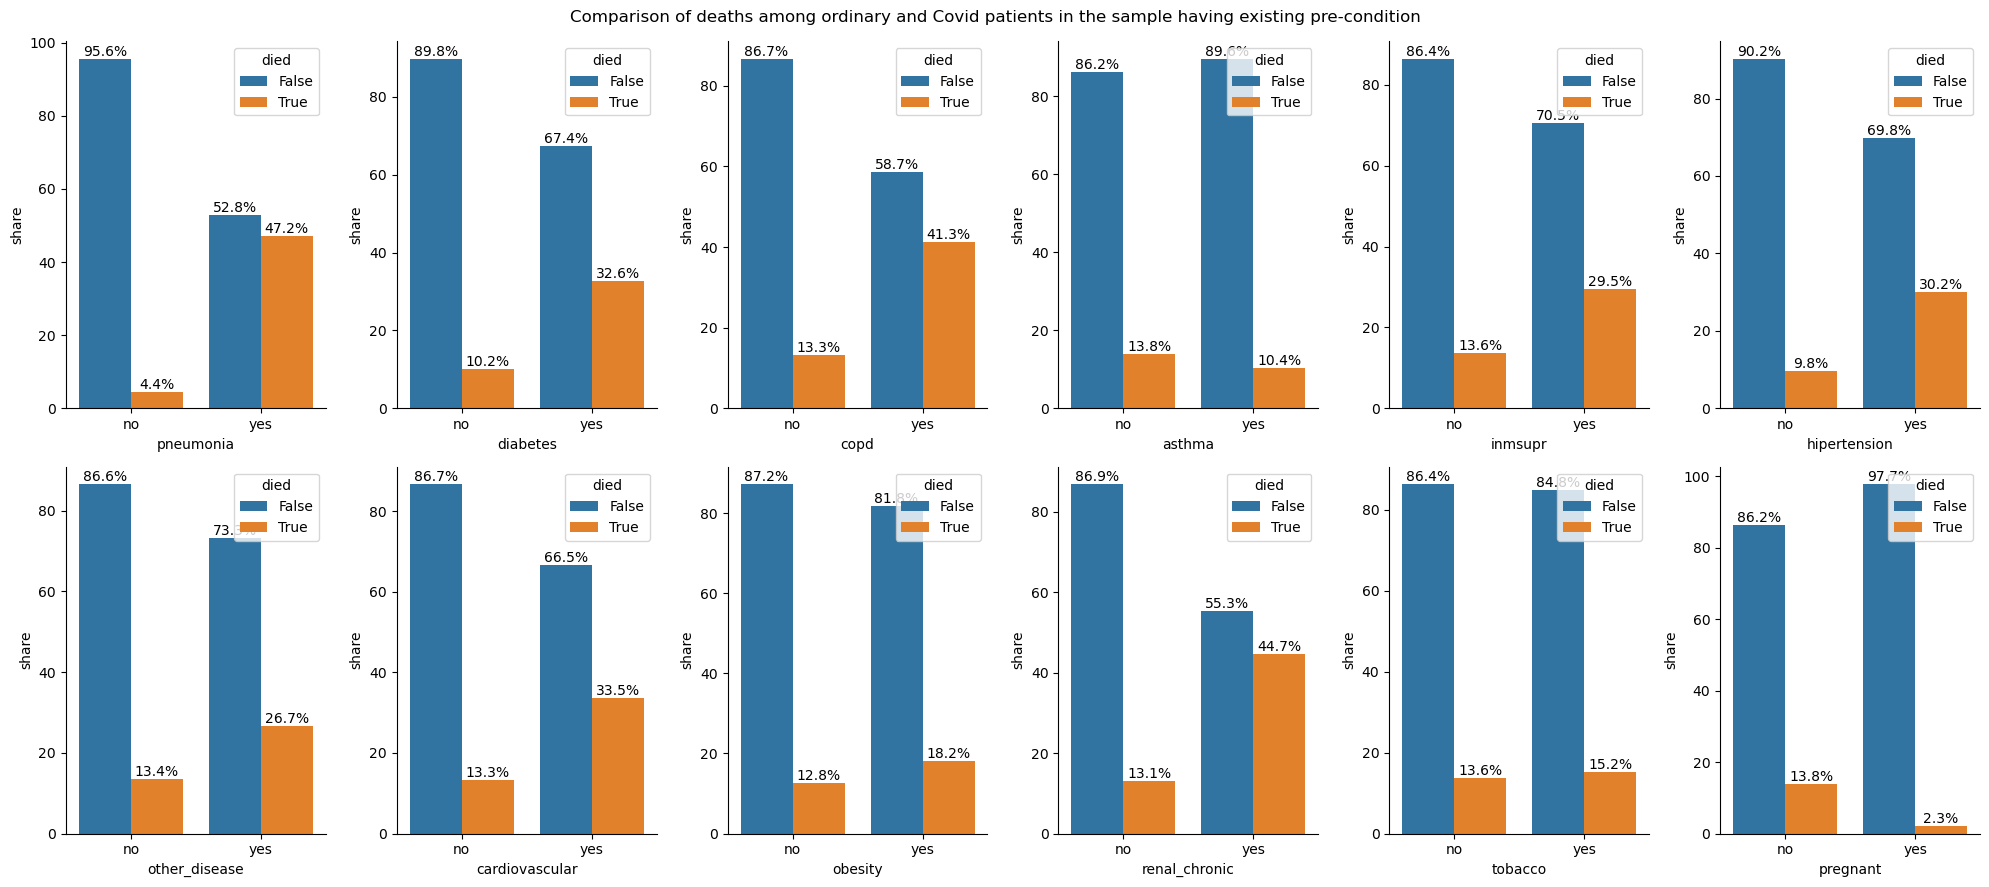

In [36]:
# how often Covid patients died with and without various pre-conditions:
# pneumonia, chronic kidney disease and chronic obstructive pulmonary disease appear to be visually obvious risk factors

fig = plt.figure(figsize=(20,9))

for num, condition in enumerate(conditions_list):
    ax = fig.add_subplot(2,6,num+1)
    sns.barplot(data=((df.loc[df['clasiffication_final']!=0].groupby(condition)['died'].value_counts(normalize=True))*100).reset_index(),
            x=condition, y='proportion', hue='died')
    values = df[condition].value_counts(ascending=False).values
    ax.set_xticklabels(['no','yes'])
    plt.xlabel(condition)
    plt.ylabel('share')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')
        
plt.suptitle('Comparison of deaths among ordinary and Covid patients in the sample having existing pre-condition')
sns.despine()
plt.tight_layout()
plt.show()

In [37]:
# dividing sample into age groups: 
# 0-18 - 0, 19-25 - 1, 25-44 - 2, 45-65 - 3, 65+ - 4

df['age_cat'] = np.where(
    df['age'] <= 18, 0, 
    np.where(
    (df['age'] > 18) & (df['age'] <= 25), 1, 
    np.where(
    (df['age'] > 25) & (df['age'] <= 44), 2, 
    np.where(
    (df['age'] > 44) & (df['age'] <= 65), 3, 4)
    )
    )
)

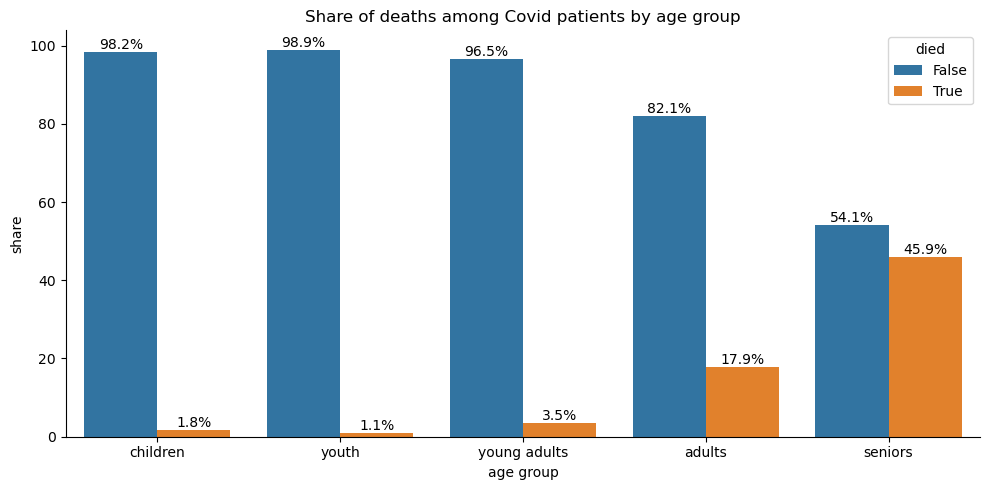

In [39]:
# it is obvious that as age increased, the likelihood of dying from covid increased as well

df_temp = df.copy()
df_temp = ((df_temp.loc[df_temp['clasiffication_final']!=0].groupby('age_cat')['died'].value_counts(normalize=True))*100).sort_values(ascending=False).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.barplot(data=df_temp, x='age_cat', y='proportion', hue='died')
ax.set_xticklabels(['children','youth','young adults','adults','seniors'])
plt.xlabel('age group')
plt.ylabel('share')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Share of deaths among Covid patients by age group')
sns.despine()
plt.tight_layout()
plt.show()

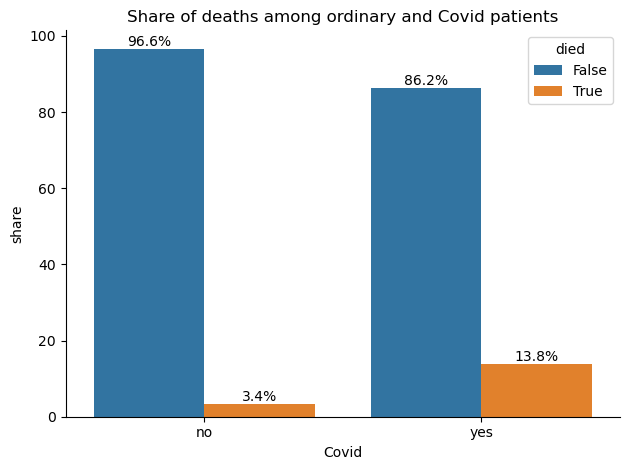

In [41]:
# share of deaths among those with Covid exceeds share among those who did not have it by more than 10 p.p.

df_temp = df.copy()
df_temp['clasiffication_final'] = df_temp['clasiffication_final'].replace({2:1,3:1})
df_temp = ((df_temp.groupby('clasiffication_final')['died'].value_counts(normalize=True))*100).reset_index()

ax = sns.barplot(data=df_temp, x='clasiffication_final', y='proportion', hue='died')
ax.set_xticklabels(['no','yes'])
plt.xlabel('Covid')
plt.ylabel('share')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Share of deaths among ordinary and Covid patients')
sns.despine()
plt.tight_layout()
plt.show()

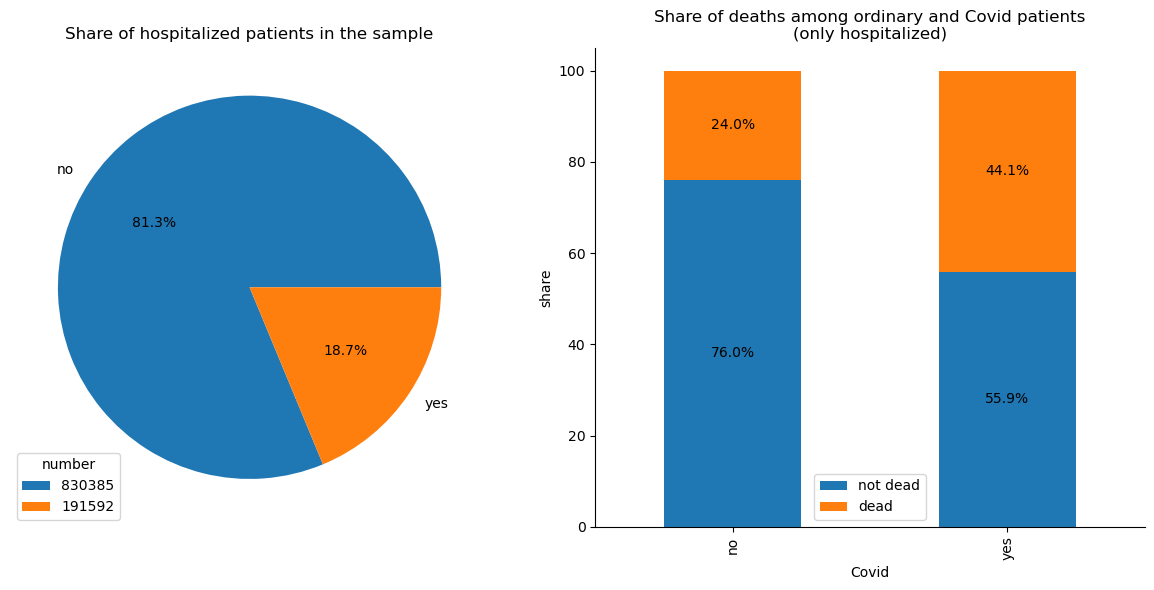

In [42]:
# in the group of hospitalized patients this gap is even larger - about 20 p.p., but they make up only about 19% of the sample

plt.figure(figsize = (12, 6))

ax1 = plt.subplot(1,2,1)

ax1.set_title('Share of hospitalized patients in the sample')
ax1.pie(df['patient_type'].value_counts(), autopct = '%1.1f%%', labels=['no','yes'])
ax1.legend(df['patient_type'].value_counts(), loc = 'lower left', title = 'number')

ax2 = plt.subplot(1,2,2)

df_temp = df.copy()
df_temp['clasiffication_final'] = df_temp['clasiffication_final'].replace({2:1,3:1})
df_temp = ((df_temp.loc[df_temp['patient_type']==0].groupby('clasiffication_final')['died'].value_counts(normalize=True))*100).reset_index()

ax2 = df_temp.set_index('clasiffication_final').pivot(columns='died').plot(kind='bar',stacked=True, ax=ax2)
ax2.set_xticklabels(['no','yes'])
ax2.set_xlabel('Covid')
ax2.set_ylabel('share')
ax2.legend(['not dead', 'dead'])
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', label_type='center')

ax2.set_title('Share of deaths among ordinary and Covid patients\n(only hospitalized)')
sns.despine()
plt.tight_layout()
plt.show()

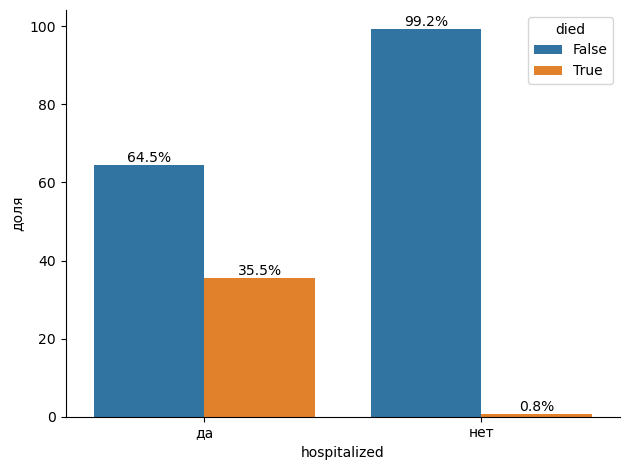

In [43]:
# the proportion of deaths among those who were not hospitalized is insignificant
# this is probably it was impossible to establish what happened to people if they were not hospitalized
# however, hospitalized people were left in the hospital based on severity of their illness

ax = sns.barplot(data=((df.groupby('patient_type')['died'].value_counts(normalize=True))*100).reset_index(), 
            x='patient_type', y='proportion',hue='died')
ax.set_xticklabels(['yes','no'])
plt.xlabel('hospitalized')
plt.ylabel('share')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

sns.despine()
plt.tight_layout()
plt.show()

In [44]:
# based on this information in the final dataset will consist of only those who were hospitalized: this will make the sample smaller and leave only reliable cases of death
# + the sample will be more balanced

df_true = df.loc[df['patient_type'] == 0].drop(columns=['age','date_died','patient_type']).reset_index(drop=True).copy()
df_true.shape

(191592, 18)

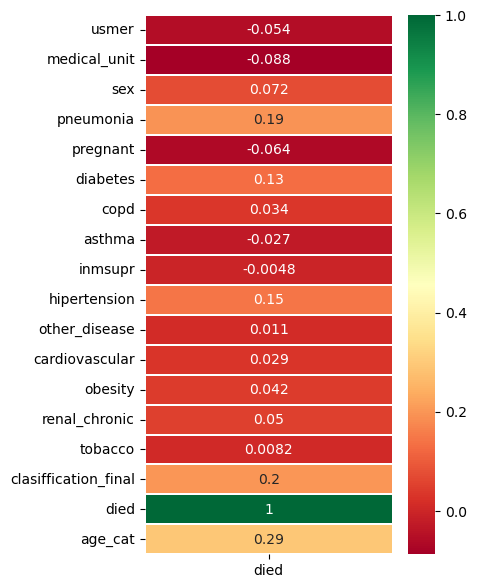

In [45]:
# no feature has high correlation with fatal outcome

corr_ = pd.DataFrame(df_true.corr()['died'])

fig = plt.figure(figsize=(4,7))

sns.heatmap(corr_, annot=True, cmap='RdYlGn', linewidth=0.1)
plt.show()

### Creation/comparison of models

Decision Tree Classifier

In [47]:
# selecting target feature and splitting dataset into train_test

y = df_true['died']
X = df_true.drop(columns=['died'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=17, stratify = y)

In [48]:
# tree without parameter optimization: there is a noticeable difference in accuracy between train and test, which may indicate overfitting

dtc = DecisionTreeClassifier(random_state=13)
dtc.fit(X_train, y_train)
print('train_acc:', dtc.score(X_train, y_train))
print('test_acc:', dtc.score(X_test, y_test))
print('f1_score:', f1_score(y_test, dtc.predict(X_test)))

train_acc: 0.7459891827001494
test_acc: 0.6991570761241159
f1_score: 0.5214214546662238


In [27]:
# parameter tuning: accuracy increased slightly for the test sample

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [2, 5, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [2, 4, 8, 12, len(X_train.columns)]
}


decision_tree = DecisionTreeClassifier(random_state=13)
grid_dt1 = GridSearchCV(estimator=decision_tree, 
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1
                       )

grid_dt1.fit(X_train, y_train)
print('best score:', grid_dt1.best_score_)
print('best params', grid_dt1.best_params_)
print('test score:', grid_dt1.score(X_test, y_test))

best score: 0.709955457968275
best params {'criterion': 'gini', 'max_depth': 10, 'max_features': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
test score: 0.7104047600407108


In [28]:
# a more narrow parameter tuning

param_grid = {
    'criterion': ['gini'],
    'splitter': ['best'],
    'max_depth': list(range(8,13)),
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [2, 3],
    'max_features': list(range(10,15))
}


decision_tree = DecisionTreeClassifier(random_state=13)
grid_dt1 = GridSearchCV(estimator=decision_tree, 
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1
                       )

grid_dt1.fit(X_train, y_train)
print('best score:', grid_dt1.best_score_)
print('best params', grid_dt1.best_params_)
print('test score:', grid_dt1.score(X_test, y_test))

best score: 0.709955457968275
best params {'criterion': 'gini', 'max_depth': 10, 'max_features': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
test score: 0.7104047600407108


died
False    24722
True     13597
Name: count, dtype: int64
f1_score:  0.5161543492478744


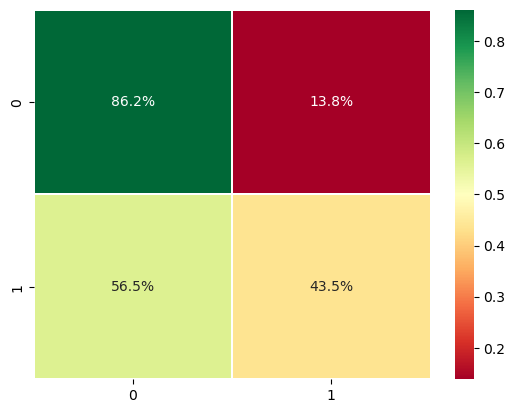

In [29]:
# f1-score and error matrix: the model predicts non-lethal outcomes quite well, but poorly predicts lethal ones
# in the future we will assume that it is equally important for us to predict both scenarios well and will aim to increase f1-score

dtc = DecisionTreeClassifier(random_state=13, **grid_dt1.best_params_).fit(X_train, y_train)
print(y_test.value_counts())
print('f1_score: ', f1_score(y_test, dtc.predict(X_test)))

sns.heatmap(confusion_matrix(y_test, dtc.predict(X_test), normalize='true'),
            annot=True, cmap='RdYlGn',linewidth=0.1, fmt='.1%', )
plt.show()

died
False    24722
True     13597
Name: count, dtype: int64
f1_score:  0.6145650500384912


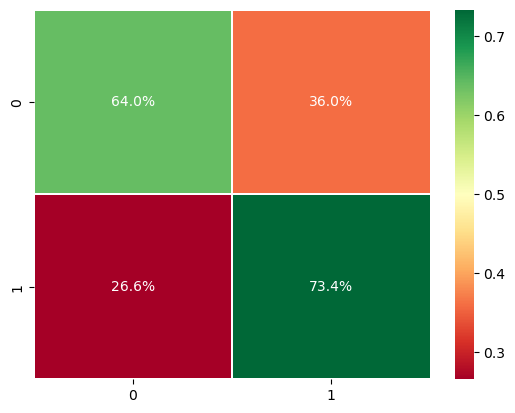

train_acc: 0.6785930985887926
test_acc: 0.6733474255591221


In [30]:
# with class weights introduced f1-score increases: the model as a whole predicts fatal outcomes better, while accuracy drops

dtc = DecisionTreeClassifier(random_state=13, **grid_dt1.best_params_, class_weight='balanced').fit(X_train, y_train)
print(y_test.value_counts())
print('f1_score: ', f1_score(y_test, dtc.predict(X_test)))

sns.heatmap(confusion_matrix(y_test, dtc.predict(X_test), normalize='true'), annot=True, cmap='RdYlGn',linewidth=0.1, fmt='.1%', )
plt.show()

print('train_acc:', dtc.score(X_train, y_train))
print('test_acc:', dtc.score(X_test, y_test))

In [31]:
# parameter tuning with class weights

param_grid = {
'criterion': ['gini', 'entropy', 'log_loss'],
'splitter': ['best', 'random'],
'max_depth': [2, 5, 10, 20, 30],
'min_samples_split': [2, 4, 5],
'min_samples_leaf': [1, 2, 4],
'max_features': [2, 4, 8, 12, len(X_train.columns)]
}

decision_tree = DecisionTreeClassifier(random_state=13, class_weight='balanced')
grid_dt2 = GridSearchCV(estimator=decision_tree, 
                        cv=10,
                        param_grid=param_grid,
                        scoring='f1',
                        n_jobs=-1)

grid_dt2.fit(X_train, y_train)
print('best score:', grid_dt2.best_score_)
print('best params', grid_dt2.best_params_)
print('test score:', grid_dt2.score(X_test, y_test))

best score: 0.6108524181965571
best params {'criterion': 'entropy', 'max_depth': 10, 'max_features': 12, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
test score: 0.6117195367573011


died
False    24722
True     13597
Name: count, dtype: int64
f1_score:  0.6117195367573011


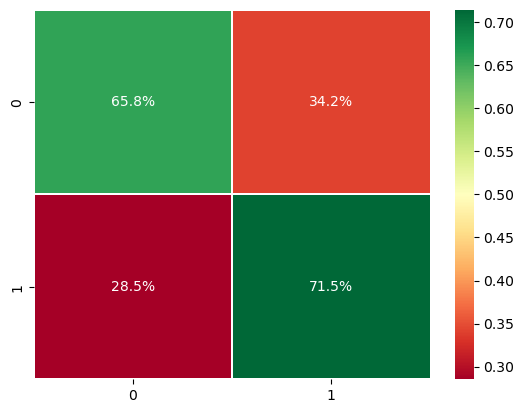

train_acc: 0.6830948699379539
test_acc: 0.6780187374409562


In [32]:
# after parameter tuning the model does not show very good results, however, f1_score has been significantly increased

dtc = DecisionTreeClassifier(random_state=13, **grid_dt2.best_params_, class_weight = 'balanced').fit(X_train, y_train)
print(y_test.value_counts())
print('f1_score: ', f1_score(y_test, dtc.predict(X_test)))

sns.heatmap(confusion_matrix(y_test, dtc.predict(X_test), normalize='true'), annot=True, cmap='RdYlGn', linewidth=0.1, fmt='.1%', )
plt.show()

print('train_acc:', dtc.score(X_train, y_train))
print('test_acc:', dtc.score(X_test, y_test))

Logistic Regression

In [33]:
# selecting target feature and splitting dataset into train_test

y = df_true['died']
X = df_true.drop(columns=['died'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=17, stratify = y)

In [34]:
# logistic regression without parameter tuning

lr = LogisticRegression(random_state=23, solver='liblinear').fit(X_train, y_train)
print('train_acc:', accuracy_score(y_train, lr.predict(X_train)))
print('test_acc:', accuracy_score(y_test, lr.predict(X_test)))
print('f1_score: ', f1_score(y_test, lr.predict(X_test)))

train_acc: 0.6979115695523673
test_acc: 0.6966256948250216
f1_score:  0.49651349127290045


In [35]:
# one hot encoder

enc = OneHotEncoder(sparse=False, drop='first')
df_enc = pd.DataFrame(enc.fit_transform(df_true[['usmer', 'medical_unit','clasiffication_final', 'age_cat']])) 
df_enc.columns = enc.get_feature_names_out(['usmer', 'medical_unit','clasiffication_final', 'age_cat'])
df_true_enc = df_true.drop(columns = ['usmer', 'medical_unit','clasiffication_final', 'age_cat'])
df_true_enc = df_true_enc.join(df_enc)

y = df_true_enc['died']
X = df_true_enc.drop(columns=['died'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=17, stratify = y)

train_acc: 0.7088985013668422
test_acc: 0.7083431196012422
f1_score:  0.5205902539464653
died
False    24722
True     13597
Name: count, dtype: int64


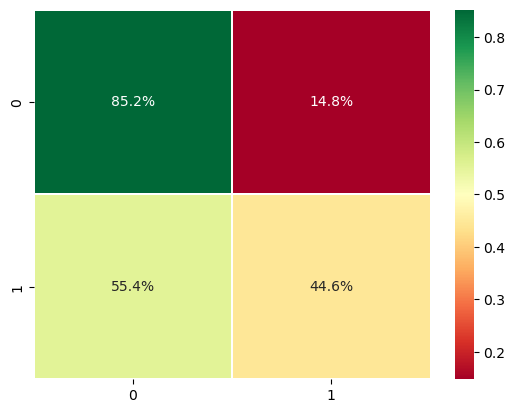

In [36]:
# accuracy, f1_score increased: model, as in the case of Decision Tree Classifier, predicts non-lethal outcomes quite well, but poorly predicts lethal ones
# in the future we will use this one_hot encoded version to select parameters

lr = LogisticRegression(random_state=23, solver='liblinear', max_iter=1000).fit(X_train, y_train)
print('train_acc:', accuracy_score(y_train, lr.predict(X_train)))
print('test_acc:', accuracy_score(y_test, lr.predict(X_test)))
print('f1_score: ', f1_score(y_test, lr.predict(X_test)))

print(y_test.value_counts())
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test), normalize='true'), annot=True, cmap='RdYlGn',linewidth=0.1, fmt='.1%', )
plt.show()

In [37]:
# parameter tuning with gradient descent; as before, we are trying to improve f1_score

param_grid = {
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced'],
    'learning_rate': ['constant', 'optimal'],
    'eta0': [0.1, 0.01],
    'alpha': np.logspace(-4, 2, 7)    
}

sgd_clf = SGDClassifier(random_state=23, max_iter=1000, loss='log')

grid_dt3 = GridSearchCV(estimator=sgd_clf,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=10,
                           n_jobs=-1)

grid_dt3.fit(X_train, y_train)
print('best score:', grid_dt3.best_score_)
print('best params', grid_dt3.best_params_)
print('test score:', grid_dt3.score(X_test, y_test))

best score: 0.6105102525662353
best params {'alpha': 0.0001, 'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'constant', 'penalty': 'l2'}
test score: 0.6055679215458564


died
False    24722
True     13597
Name: count, dtype: int64
f1_score:  0.6055679215458564


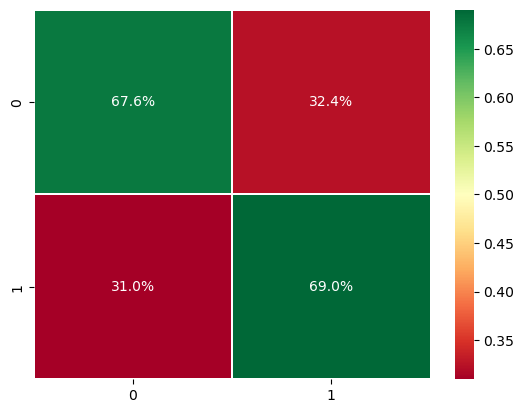

train_acc: 0.6787562062463709
test_acc: 0.6809154727419818


In [38]:
# in general, model results are slightly better than in the case of Decision Tree Classifier - it has higher accuracy and f1_score in the test

clf = SGDClassifier(random_state=23, max_iter=1000, loss='log', **grid_dt3.best_params_).fit(X_train, y_train)

print(y_test.value_counts())
print('f1_score: ', f1_score(y_test, clf.predict(X_test)))

sns.heatmap(confusion_matrix(y_test, clf.predict(X_test), normalize='true'), annot=True, cmap='RdYlGn', linewidth=0.1, fmt='.1%', )
plt.show()

print('train_acc:', clf.score(X_train, y_train))
print('test_acc:', clf.score(X_test, y_test))